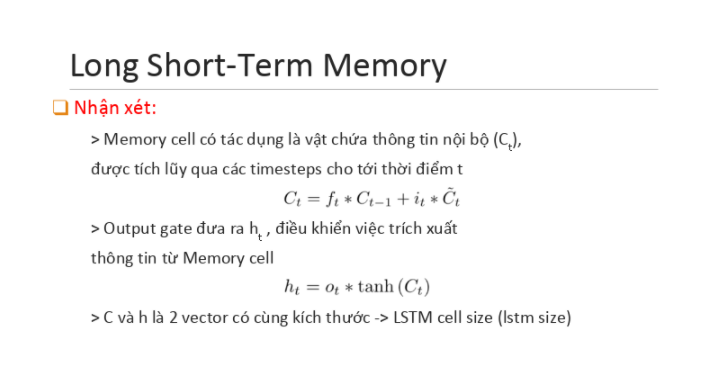

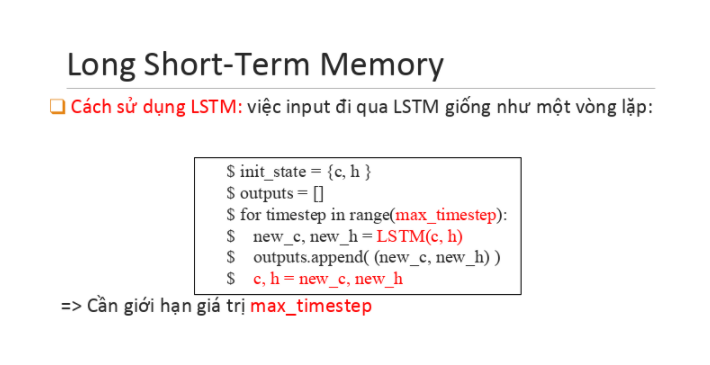

# **1. Xử lý dữ liệu**

- Xử lý qua file *.py ở máy tính cá nhân
- File dữ liệu sau khi xử lý nằm ở folder data

# **2. Xây dựng mô hình**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
MAX_SENTENCE_LENGTH = 500
NUM_CLASSES = 20

### **a. class RNN**

In [3]:
class RNN:
  def __init__(self,
               vocab_size,
               embedding_size,
               lstm_size,
               batch_size):
    self._vocab_size = vocab_size
    self._embedding_size = embedding_size
    self._lstm_size = lstm_size
    self._batch_size = batch_size

    self._data = tf.placeholder(tf.int32, shape=[batch_size, MAX_SENTENCE_LENGTH])
    self._labels = tf.placeholder(tf.int32, shape=[batch_size, ])
    self._sentence_lengths = tf.placeholder(tf.int32, shape=[batch_size, ])
    self._final_tokens = tf.placeholder(tf.int32, shape=[batch_size, ])


  def embedding_layer(self, indices):
    pretrained_vectors = []
    pretrained_vectors.append(np.zeros(self._embedding_size))
    np.random.seed(2021)
    for _ in range (self._vocab_size + 1):
      pretrained_vectors.append(np.random.normal(loc=0., scale=1., size=self._embedding_size))

    pretrained_vectors = np.array(pretrained_vectors)

    self._embedding_matrix = tf.get_variable(
        name='embedding',
        shape=(self._vocab_size + 2, self._embedding_size),
        initializer=tf.constant_initializer(pretrained_vectors)
    )
    return tf.nn.embedding_lookup(self._embedding_matrix, indices)


  def LSTM_layer(self, embeddings):
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(self._lstm_size)
    zero_state = tf.zeros(shape=(self._batch_size, self._lstm_size))
    initial_state = tf.nn.rnn_cell.LSTMStateTuple(zero_state, zero_state)

    lstm_inputs = tf.unstack(
        tf.transpose(embeddings, perm=[1, 0, 2])
    )
    lstm_outputs, last_state = tf.nn.static_rnn(
        cell=lstm_cell,
        inputs=lstm_inputs,
        initial_state=initial_state,
        sequence_length=self._sentence_lengths
    ) # a length-500 list of [num_docs, lstm_size]
    lstm_outputs = tf.unstack(
        tf.transpose(lstm_outputs, perm=[1, 0, 2])
    )
    lstm_outputs = tf.concat(
        lstm_outputs,
        axis=0
    ) # [num_docs * MAX_SENTENCE_LENGTH, lstm_size]

    # self._mask : [num_docs * MAX_SENT_LENGTH, ]
    mask = tf.sequence_mask(
        lengths=self._sentence_lengths,
        maxlen=MAX_SENTENCE_LENGTH,
        dtype=tf.float32
    ) # [num_docs, MAX_SENTENCE_LENGTH]
    mask = tf.concat(tf.unstack(mask, axis=0), axis=0)
    mask = tf.expand_dims(mask, -1)

    lstm_outputs = mask * lstm_outputs
    lstm_outputs_split = tf.split(lstm_outputs, num_or_size_splits=self._batch_size)
    lstm_outputs_sum = tf.reduce_sum(lstm_outputs_split, axis=1)
    lstm_outputs_average = lstm_outputs_sum / tf.expand_dims(
        tf.cast(self._sentence_lengths, tf.float32),
        -1
    ) # expand_dims only works with tensor of float type
      # [num_docs, lstm_size]

    return lstm_outputs_average


  def build_graph(self):
    embeddings = self.embedding_layer(self._data)
    lstm_outputs = self.LSTM_layer(embeddings)

    weigths = tf.get_variable(
        name = 'final_layer_weights',
        shape = (self._lstm_size, NUM_CLASSES),
        initializer = tf.random_normal_initializer(seed = 2021)
    )
    biases = tf.get_variable(
        name = 'final_layer_biases',
        shape = (NUM_CLASSES),
        initializer = tf.random_normal_initializer(seed = 2021)
    )
    logits = tf.matmul(lstm_outputs, weigths) + biases

    labels_one_hot = tf.one_hot(
        indices = self._labels,
        depth = NUM_CLASSES,
        dtype = tf.float32
    )

    loss = tf.nn.softmax_cross_entropy_with_logits(
        labels = labels_one_hot,
        logits = logits
    )
    loss = tf.reduce_mean(loss)

    probs = tf.nn.softmax(logits)
    predicted_labels = tf.argmax(probs, axis = 1)
    predicted_labels = tf.squeeze(predicted_labels)
    return predicted_labels, loss


  def trainer(self, loss, learning_rate):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return train_op

### **b. class DataReader**

In [4]:
class DataReader:
  def __init__(self, data_path, batch_size):
    self._batch_size = batch_size
    with open(data_path) as f:
      d_lines = f.read().splitlines()

    self._data = []
    self._labels = []
    self._sentence_lengths = []
    self._final_tokens = [] 
    for data_id, line in enumerate(d_lines):
      features = line.split('<fff>')
      label, doc_id, sentence_length = int(features[0]), int(features[1]), int(features[2])
      tokens = features[3].split()

      self._data.append(tokens)
      self._sentence_lengths.append(sentence_length)
      self._labels.append(label)
      self._final_tokens.append(tokens[-1])

    self._data = np.array(self._data)
    self._labels = np.array(self._labels)
    self._sentence_lengths = np.array(self._sentence_lengths)
    self._final_tokens = np.array(self._final_tokens)

    self._num_epoch = 0
    self._batch_id = 0
    self._size = len(self._data)

  def next_batch(self):
    start = self._batch_id * self._batch_size
    end = start + self._batch_size
    self._batch_id += 1

    if end + self._batch_size > len(self._data):
      self._size = end
      end = len(self._data)
      start = end - self._batch_size
      self._num_epoch += 1
      self._batch_id = 0
      indices = list(range(len(self._data)))
      random.seed(2021)
      random.shuffle(indices)
      self._data, self._labels, self._sentence_lengths, self._final_tokens = self._data[indices], self._labels[indices], self._sentence_lengths[indices], self._final_tokens[indices]

    return self._data[start:end], self._labels[start:end], self._sentence_lengths[start:end], self._final_tokens[start:end]

### **c. Training**

In [5]:
loss_report = []
accuracy_report = []

In [6]:
def train_and_evaluate_RNN():
  with open('/content/drive/MyDrive/Colab Notebooks/DSLAB TRAINING/SESSION 4/data/vocab-raw.txt') as f:
      vocab_size = len(f.read().splitlines())

  tf.set_random_seed(2021)
  rnn = RNN(
      vocab_size=vocab_size,
      embedding_size=300,
      lstm_size=50,
      batch_size=50
  )
  predicted_labels, loss = rnn.build_graph()
  train_op = rnn.trainer(loss=loss, learning_rate=0.01)

  with tf.Session() as sess:
    train_data_reader = DataReader(
        data_path='/content/drive/MyDrive/Colab Notebooks/DSLAB TRAINING/SESSION 4/data/20news-train-encoded.txt',
        batch_size=50,
    )
    test_data_reader = DataReader(
        data_path='/content/drive/MyDrive/Colab Notebooks/DSLAB TRAINING/SESSION 4/data/20news-test-encoded.txt',
        batch_size=50,
    )
    step = 0
    MAX_STEP = 10000
    
    sess.run(tf.global_variables_initializer())
    while step < MAX_STEP:
        next_train_batch = train_data_reader.next_batch()
        train_data, train_labels, train_sentence_lengths, train_final_tokens = next_train_batch
        plabels_eval, loss_eval, _ = sess.run(
            [predicted_labels, loss, train_op],
            feed_dict={
                rnn._data: train_data,
                rnn._labels: train_labels,
                rnn._sentence_lengths: train_sentence_lengths,
                rnn._final_tokens: train_final_tokens
            }
        )
        step += 1
        if step % 20 == 0:
          loss_report.append(loss_eval)
          print('loss: {}'.format(loss_eval))
        if train_data_reader._batch_id == 0:
          num_true_preds = 0
          while True:
            next_test_batch = test_data_reader.next_batch()
            test_data, test_labels, test_sentence_lengths, test_final_tokens = next_test_batch
            test_plabels_eval = sess.run(
                predicted_labels,
                feed_dict={
                    rnn._data: test_data,
                    rnn._labels: test_labels,
                    rnn._sentence_lengths: test_sentence_lengths,
                    rnn._final_tokens: test_final_tokens
                }
            )
            matches = np.equal(test_plabels_eval, test_labels)
            num_true_preds += np.sum(matches.astype(float))

            if test_data_reader._batch_id == 0:
              break

          accuracy_report.append(num_true_preds * 100. / test_data_reader._size)        
          print('Epoch: {}'.format(train_data_reader._num_epoch))
          print('Accuracy on test data: {}'.format(num_true_preds * 100. / test_data_reader._size))

In [7]:
train_and_evaluate_RNN()

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

loss: 0.5393667221069336
loss: 5.971556186676025
loss: 2.3458964824676514
loss: 4.631790637969971
loss: 2.9802989959716797
loss: 3.558422565460205
loss: 4.648012161254883
Epoch: 1
Accuracy on test data: 5.8584070796460175
loss: 3.021846055984497
loss: 2.3508918285369873
loss: 2.2129294872283936
loss: 2.0007004737854004
loss: 1.875797152519226
loss: 1.7115473747253418
loss: 1.6418519020080566
loss: 1.100526213645935
Epoch: 2
Accuracy on test data: 65.50442477876106
loss: 1.1207716464996338
loss: 0.9574071764945984
loss: 1.2043794393539429
loss: 0.9020517468452454
loss: 0.8043932318687439
loss: 0.7984666228294373
loss: 0.6014195084571838
Epoch: 3
Accuracy on test data: 72.23893805309734
loss: 0.34263575077056885
loss: 0.36814674735069275
loss: 0.38001251220703125
loss: 0.31527698040008545
loss: 0.303

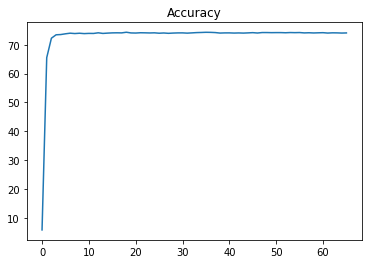

In [8]:
plt.plot(accuracy_report)
plt.title("Accuracy")
plt.show()

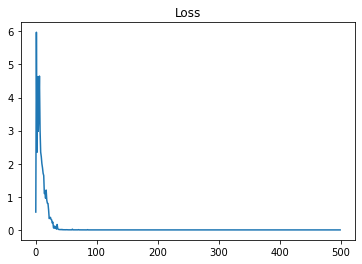

In [9]:
plt.plot(loss_report)
plt.title("Loss")
plt.show()